**Group information**

| Family name | First name | Student #  | BSE email     |
| ----------- | ---------- | ---------- | ------------- |
|      Frey       |  Eric          |      1      |       eric.frey@bse.eu        |
|      Manotas       |    Santiago        |      2      |    santiago.manotasarroyave@bse.eu           |

# Deep learning applications - Homework 1

This practice session aims to extract automatically building footprints from aerial images of the state of Massachusetts. We want to approximate the function mapping input images to a binary prediction for each pixel (i.e. semantic segmentation) using the U-Net convolutional network architecture [(Ronneberger et al. 2015)](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). For this assignment, the GPU implementation of TensorFlow is recommended, but students preferring PyTorch can use this framework instead.

The image data consists of 3347 colour raster of dimension 256x256x3 using the NAD83 (EPSG:26986) projection system. Each raster represents an area of 300 square meters. The label data consists of building footprints vectors extracted from [OpenStreetMap](https://www.openstreetmap.org/relation/61315) and converted into a binary raster with the same extent and resolution as the image rasters. The unformatted data was provided by Minh (2013) and can be accessed on his [website](http://www.cs.toronto.edu/~vmnih/data/). Images and labels are randomly partitioned into a training (70%) validation (15%) and test sample (15%).

Tensorflow Keras documentation:
- [Convolution](https://keras.io/api/layers/convolution_layers/)
- [Activation](https://keras.io/api/layers/activations/)
- [Pooling](https://keras.io/api/layers/pooling_layers/)
- [Regularisation](https://keras.io/api/layers/regularization_layers/)
- [Optimisers](https://keras.io/api/optimizers/)
- [Metrics](https://keras.io/api/metrics/)
- [Losses](https://keras.io/api/losses/)
- [Callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks)

![U-Net model](img/homework_model.jpg)

In [1]:
# Modules
import numpy as np
import tensorflow

from tensorflow.keras import callbacks, layers, losses, metrics, models, optimizers, preprocessing, utils
from homework_utilities import *

2023-04-28 13:30:16.893662: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


No supported GPU was found.


In [2]:
# Checks tensorFlow
print('TensorFlow version:', tensorflow.__version__)
print('GPU available:', len(tensorflow.config.list_physical_devices('GPU')))

# Defines paths
paths = dict(
    images_train='data/training/images',
    labels_train='data/training/labels',
    images_valid='data/validation/images',
    labels_valid='data/validation/labels',
    images_test= 'data/test/images',
    labels_test= 'data/test/labels'
)

TensorFlow version: 2.12.0
GPU available: 0


1. Load the images and labels for the training and validation samples as separate `numpy.ndarray` of dimensions $n \times h \times w \times d$. You can use the provided `search_files` and `read_raster` utility functions. Normalise the images between 0 and 1 and set the labels data type as float.

In [7]:
# Loads training data
images_train   = np.array([read_raster(file, dtype=np.ubyte)  for file in search_files(paths['images_train'],   pattern='tif$')])/255
labels_train   = np.array([read_raster(file, dtype=np.ubyte)  for file in search_files(paths['labels_train'],   pattern='tif$')]).astype(float)

# Loads validation data
images_valid =  np.array([read_raster(file, dtype=np.ubyte)  for file in search_files(paths['images_valid'],   pattern='tif$')])/255
labels_valid   = np.array([read_raster(file, dtype=np.ubyte)  for file in search_files(paths['labels_valid'],   pattern='tif$')]).astype(float)

2. For the training and validation samples, check the dimensions of the images and labels arrays. Display several matching image and label pairs to ensure correspondence. You can use the provided `compare` utility function.

In [8]:
images_train

array([[[[0.17254902, 0.23137255, 0.19607843],
         [0.4745098 , 0.47058824, 0.34117647],
         [0.3372549 , 0.32941176, 0.23137255],
         ...,
         [0.35686275, 0.35294118, 0.31764706],
         [0.24313725, 0.23921569, 0.21568627],
         [0.27843137, 0.27058824, 0.23921569]],

        [[0.54117647, 0.50980392, 0.42352941],
         [0.38823529, 0.40784314, 0.28235294],
         [0.20784314, 0.23529412, 0.14509804],
         ...,
         [0.25490196, 0.2627451 , 0.22745098],
         [0.25098039, 0.24705882, 0.18823529],
         [0.29019608, 0.28235294, 0.23137255]],

        [[0.43529412, 0.41568627, 0.40392157],
         [0.19607843, 0.25490196, 0.15686275],
         [0.18039216, 0.27058824, 0.12156863],
         ...,
         [0.28627451, 0.28235294, 0.21960784],
         [0.29019608, 0.27843137, 0.23137255],
         [0.3372549 , 0.3254902 , 0.27843137]],

        ...,

        [[0.42352941, 0.41176471, 0.42352941],
         [0.32941176, 0.32941176, 0.33333333]

Training dimensions:
img dim:(2343, 256, 256, 3)
label dim:(2343, 256, 256, 1)
Validation dimensions:
img dim:(502, 256, 256, 3)
label dim:(502, 256, 256, 1)
train sample:


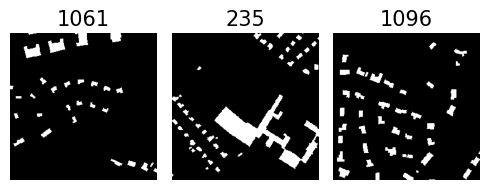

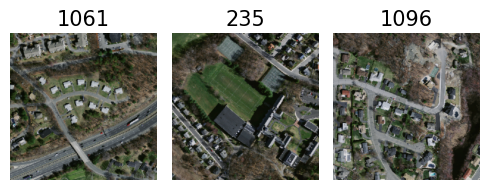

validation sample:


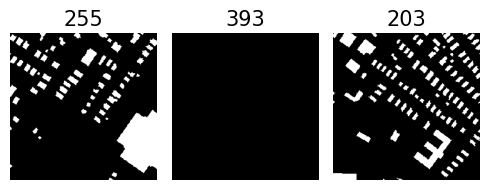

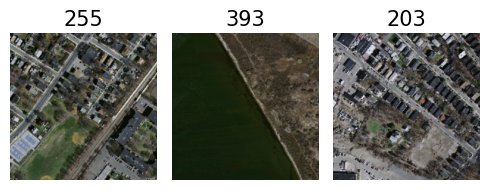

In [9]:
# Check the dimensions
print('''Training dimensions:\nimg dim:{}\nlabel dim:{}'''.format(images_train.shape, labels_train.shape))
print('''Validation dimensions:\nimg dim:{}\nlabel dim:{}'''.format(images_valid.shape, labels_valid.shape))

# Display several matching img and label pairs to ensure correspondence
np.random.seed(1)
train_sample = np.random.choice(images_train.shape[0], 3)
valid_sample = np.random.choice(images_valid.shape[0], 3)


print('train sample:')
compare(images= labels_train[train_sample], titles= train_sample)
compare(images= images_train[train_sample], titles= train_sample)

print('validation sample:')
compare(images= labels_valid[valid_sample], titles= valid_sample)
compare(images= images_valid[valid_sample], titles= valid_sample)

3. Using the Keras functional API, define a simplified U-Net model with the number of kernels indicated in the figure above (i.e. 8, 16, 32, 64, 128, ...). There are numerous implementation examples of U-Nets using Keras. Choose the appropriate activation functions for the hidden layers and the output layer, and the corresponding parameter initialisation method.

In [110]:
# bottleneck
def double_conv_block(x, n_filters, padding='same'):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding=padding, activation="relu")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding=padding, activation="relu")(x)
   return x

# Encoder
def downsample_block(x, n_filters, padding='same'):
   f = double_conv_block(x, n_filters, padding)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return p, f 

# Decoder
def upsample_block(x, conv_features, n_filters, padding='same'):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 2, strides=2, padding=padding)(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [111]:
from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

# Define the input shape
inputs = layers.Input(shape=(256, 256, 3))

pool1, skip1 = downsample_block(inputs, 8)
pool2, skip2 = downsample_block(pool1, 16)
pool3, skip3 = downsample_block(pool2, 32)
pool4, skip4 = downsample_block(pool3, 64)

# Define the bottleneck
bottleneck = double_conv_block(pool4, 32)

# Define the decoder
u1 = upsample_block(bottleneck, skip4, 64)
u2 = upsample_block(u1, skip3, 32)
u3 = upsample_block(u2, skip2, 16)
u4 = upsample_block(u3, skip1, 8)

output = layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u4)

model = Model(inputs=inputs, outputs=output)

4. Initialise and compile the model using the chosen optimisation algorithm and the appropriate loss function. Optionally, you can use the focal version of the loss function to account for the class imbalance in the training data. Print the model structure using the `summary` method.

In [112]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_45 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_427 (Conv2D)            (None, 256, 256, 8)  224         ['input_45[0][0]']               
                                                                                                  
 conv2d_428 (Conv2D)            (None, 256, 256, 8)  584         ['conv2d_427[0][0]']             
                                                                                                  
 max_pooling2d_154 (MaxPooling2  (None, 128, 128, 8)  0          ['conv2d_428[0][0]']       

5. Estimate the model parameters using the training and the validation sample. Use batch-size of 32 and a maximum of 30 training epoch. Use an early-stopping callback with a patience parameter of 3 to recover the parameters that minimise the error on the validation sample.

In [113]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history = model.fit(train_image, train_label, batch_size=32, epochs=30, validation_data=(validation_image, validation_label), callbacks=[early_stopping])


Epoch 1/30
74/74 [==============================] - 235s 3s/step - loss: 0.4411 - accuracy: 0.1149 - val_loss: 0.3297 - val_accuracy: 0.1173
Epoch 2/30
74/74 [==============================] - 209s 3s/step - loss: 0.3050 - accuracy: 0.1149 - val_loss: 0.2924 - val_accuracy: 0.1173
Epoch 3/30
74/74 [==============================] - 211s 3s/step - loss: 0.2792 - accuracy: 0.1149 - val_loss: 0.2621 - val_accuracy: 0.1173
Epoch 4/30
74/74 [==============================] - 213s 3s/step - loss: 0.2580 - accuracy: 0.1149 - val_loss: 0.2446 - val_accuracy: 0.1173
Epoch 5/30
74/74 [==============================] - 212s 3s/step - loss: 0.2429 - accuracy: 0.1149 - val_loss: 0.2350 - val_accuracy: 0.1173
Epoch 6/30
74/74 [==============================] - 208s 3s/step - loss: 0.2316 - accuracy: 0.1149 - val_loss: 0.2206 - val_accuracy: 0.1173
Epoch 7/30
74/74 [==============================] - 205s 3s/step - loss: 0.2215 - accuracy: 0.1149 - val_loss: 0.2184 - val_accuracy: 0.1173
Epoch 8/30
74

In [140]:
from datetime import date
today = str(date.today())
model.save(today + 'model', save_format='h5')

6. Display the evolution of the training and validation metrics during training using the provided `display_history` utility function. Load and format the test sample (see question 1) and evaluate the model's generalisation performance.

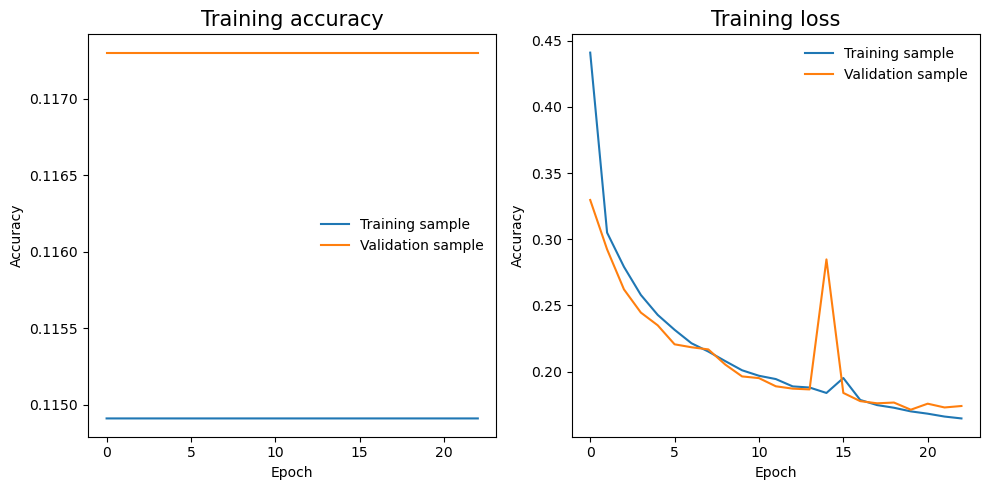

In [126]:
display_history(history.history)

7. Compute the predicted probabilities for the test images. Turn the probabilities into binary predictions using a threshold of 0.5. Display prediction statistics using the provided `display_statistics` utility for several test images.

In [127]:
# Loads test data
images_test   = np.array([read_raster(file, dtype=np.ubyte)  for file in search_files(paths['images_test'],   pattern='tif$')])/255
labels_test   = np.array([read_raster(file, dtype=np.ubyte)  for file in search_files(paths['labels_test'],   pattern='tif$')]).astype(float)

In [139]:
# compute predictions
predictions = model.predict(images_test, verbose=0)

# convert proba to binary
predictions_label = np.where(predictions> 0.5, 1 , 0)

# sample 3 randomly
np.random.seed(1)
sample = np.random.choice(predictions.shape[0], 3).tolist()

# display
for i in sample:
    display_statistics(images_test[i], labels_test[i], predictions_label[i], predictions_label[i])


array([[[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]], dtype=float32)

8. **OPTIONAL** Modify the network with either batch-normalisation or spatial dropout layers to increase predictive performance. Assuming that we give equal importance to reducing false positives and false negatives, use a decision probability threshold that strikes the best balance between these two quantities.